This notebook contains our first CNN without transfer learning, built on the first days of the challenge. It reached a score of 0.86888, after around 15 submissions, but seeing the results with TL we abandoned it and switched to more complicated structures. 

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

We import libraries, set the seed and the working directory.


In [ ]:
import os
import tensorflow as tf
import numpy as np

SEED = 27091997
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We build the generator, we decide the splitting into training and validation set and we augment the training data with only the "admissible" tranformations(for example no vertical flip).
Augmentation doesn't influence too much the model, but it's slightly better because of the scarcity of data.
Proportion of validation is very low but enough to be reliable, and so we use the most we can for training.

In [ ]:
# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(width_shift_range=10,
                                        height_shift_range=10,
                                        brightness_range=[0.5, 1.5],
                                        zoom_range=[0.9, 1.4],
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest',
                                        cval=0,
                                        rescale=1./255,                                        
                                        validation_split = 0.05)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        validation_split = 0.05)


We import the data and we create a dataframe with the images and their lables.

In [ ]:
import pandas as pd
import json

# unzip 
!unzip '/content/drive/My Drive/artificial-neural-networks-and-deep-learning-2020.zip'

# setting the diectory 
dataset_dir = os.path.join(cwd,'MaskDataset')

# image classes
with open(os.path.join(dataset_dir,'train_gt.json')) as f:
  dic = json.load(f)
dataframe = pd.DataFrame(dic.items())

# create and shuffle dataframe
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe['class'] = dataframe['class'].astype(str)
dataframe = dataframe.sample(frac=1,random_state=27091997).reset_index(drop=True)

Output streaming troncato alle ultime 5000 righe.
  inflating: MaskDataset/training/10891.jpg  
  inflating: MaskDataset/training/10892.jpg  
  inflating: MaskDataset/training/10894.jpg  
  inflating: MaskDataset/training/10899.jpg  
  inflating: MaskDataset/training/10901.jpg  
  inflating: MaskDataset/training/10902.jpg  
  inflating: MaskDataset/training/10905.jpg  
  inflating: MaskDataset/training/10906.jpg  
  inflating: MaskDataset/training/10907.jpg  
  inflating: MaskDataset/training/10908.jpg  
  inflating: MaskDataset/training/10911.jpg  
  inflating: MaskDataset/training/10913.jpg  
  inflating: MaskDataset/training/10915.jpg  
  inflating: MaskDataset/training/10916.jpg  
  inflating: MaskDataset/training/10917.jpg  
  inflating: MaskDataset/training/10919.jpg  
  inflating: MaskDataset/training/10920.jpg  
  inflating: MaskDataset/training/10921.jpg  
  inflating: MaskDataset/training/10922.jpg  
  inflating: MaskDataset/training/10923.jpg  
  inflating: MaskDataset/train

We define the batch size, we fix the dimensions of the images and the number of classes.

In [ ]:
# Batch size
bs = 64        # Since we have a simple model, batch size can be fairly big without computational issues

# img shape
img_h = 128    # We fix the dimensions of the images: this value seems to us a good compromise in order to avoid to increase too much the 
img_w = 128    # dimension of the problem but maintaining a good resolution

# classes
num_classes=3

We read the images from the dataframe created before.

In [ ]:
# Training
training_dir = os.path.join(dataset_dir, 'training')

train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)  

# Validation
valid_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs, 
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='validation',
                                               seed=SEED)


Found 5334 validated image filenames belonging to 3 classes.
Found 280 validated image filenames belonging to 3 classes.


Now we can use the defined generators. Set on repeat in order to reuse the same images.

In [ ]:
#We now finally get the training and validation datasets from the generators

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
# Repeat
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

We look at the images in one of the batches to see if there are errors and to grasp possible challenges of the problem.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(64, 128, 128, 3)

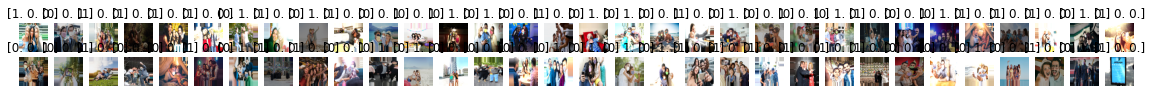

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(bs):
      ax = plt.subplot(bs/2,bs/2,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

image_batch, label_batch = next(valid_gen)
show_batch(image_batch, label_batch)
image_batch.shape

Now we construct our architecture. After some trial and error we found this one, pretty standard but with 
1. Xavier initialization
2. Batch normalization
3. Dropout to overcome overfitting
4. Progressively enlargement of number of filters
5. No regularization or complicate activation functions

In [ ]:
# Architecture: Features extraction -> Classifier

from tensorflow.keras import initializers
from tensorflow.keras import regularizers
model = tf.keras.Sequential()

# Features extraction

model.add(tf.keras.layers.Conv2D(filters=32, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[img_h, img_w, 3], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[None], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[None], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=64, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[img_h, img_w, 3], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[None], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
   
model.add(tf.keras.layers.Conv2D(filters=128, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[None], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=128, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=[None], 
                                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())


# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [ ]:
# Visualize created model
model.summary()

# Visualize initialized weights
#model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        2

We compile the model 

In [ ]:
# Optimization parameters

# Loss
loss = tf.keras.losses.CategoricalCrossentropy() # Standard choice

# learning rate 
lr = 1e-3   # After some trials, we have found this lr to be good enough to train quickly 
            # without oscillating too much around the final solution

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  # Adadelta didn't improve on this


# Validation metrics
metrics = ['accuracy'] # Choice from the challenge


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


We add some callbacks: tensorboard to monitor learning, early stopping to stop overfit and the learning rate adapter to refine search for minima during training. Then we train the model. (Normally it stops much before 100 epochs)

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir /content/drive/My\ Drive/AN2DL/classification_experiments/ --port 6009

In [ ]:
import os
from datetime import datetime

cwd = '/content/drive/My Drive/AN2DL'
exps_dir = os.path.join(cwd, 'classification_experiments')

# we are creating a list of callbacks 
callbacks = []
exp_name = 'Prova'
now = datetime.now().strftime('%b%d_%H-%M-%S')
exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  
callbacks.append(tb_callback)


#We add an earlystopping callback  
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

callbacks.append(es_callback)

#We add a learning rate adapter callback
LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0)   

callbacks.append(LR_adapter_callback)

#We fit the model
model.fit(x=train_dataset,
          epochs=100,  
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks,
          verbose = 1) #We like to monitor the accuracy during training live ()

Epoch 1/100
84/84 [==============================] - 57s 682ms/step - loss: 1.6607 - accuracy: 0.3328 - val_loss: 1.1287 - val_accuracy: 0.3321
Epoch 2/100
84/84 [==============================] - 56s 665ms/step - loss: 1.3945 - accuracy: 0.3435 - val_loss: 1.1282 - val_accuracy: 0.3286
Epoch 3/100
84/84 [==============================] - 56s 663ms/step - loss: 1.2778 - accuracy: 0.3433 - val_loss: 1.1067 - val_accuracy: 0.3464
Epoch 4/100
84/84 [==============================] - 56s 665ms/step - loss: 1.2115 - accuracy: 0.3583 - val_loss: 1.1022 - val_accuracy: 0.3107
Epoch 5/100
84/84 [==============================] - 56s 663ms/step - loss: 1.1822 - accuracy: 0.3483 - val_loss: 1.0923 - val_accuracy: 0.3750
Epoch 6/100
84/84 [==============================] - 56s 662ms/step - loss: 1.1342 - accuracy: 0.3772 - val_loss: 1.0955 - val_accuracy: 0.3536
Epoch 7/100
84/84 [==============================] - 56s 664ms/step - loss: 1.1108 - accuracy: 0.3930 - val_loss: 1.0855 - val_accuracy:

Now we make predictions on the test set and we create a csv file with the results.

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image
image_filenames = next(os.walk(os.path.join(dataset_dir, 'test')))[2]

results = {}
for image_name in image_filenames:

   img = Image.open(os.path.join(dataset_dir, 'test')+'/'+image_name).convert('RGB')
   img=img.resize((img_h, img_w))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0) 
   img_array = np.true_divide(img_array,255)
   predictions=model.predict(img_array)
   prediction = np.argmax(predictions)  #predicted class 
   results[image_name] = prediction

create_csv(results, '/content/drive/My Drive')